## This notebook shows how you can use the `fastplotlib` API to link `Graphic` objects together

In [1]:
import numpy as np
from fastplotlib.layouts import GridPlot
from fastplotlib.graphics import *
from fastplotlib import Plot
from mesmerize_core import *

2023-01-25 11:41:44.469073: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-25 11:41:44.565712: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-01-25 11:41:44.568598: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/caitlin/venvs/mescore/lib/python3.9/site-packages/cv2/../../lib64:
2023-01-25

In [2]:
set_parent_raw_data_path("/home/caitlin/caiman_data/")

PosixPath('/home/caitlin/caiman_data')

In [3]:
batch_path = get_parent_raw_data_path().joinpath("mesmerize-batch/batch.pickle")

In [4]:
df = load_batch(batch_path)

In [5]:
df

,algo,item_name,input_movie_path,params,outputs,added_time,ran_time,algo_duration,comments,uuid
0,mcorr,Sue_2x_3000_40_-46,example_movies/Sue_2x_3000_40_-46.tif,"{'main': {'max_shifts': (24, 24), 'strides': (...",{'mean-projection-path': a369b894-cd04-46b0-b4...,2023-01-25T11:00:13,2023-01-25T11:00:39,20.57 sec,None,a369b894-cd04-46b0-b4fc-21eb211012a5
1,cnmf,Sue_2x_3000_40_-46,a369b894-cd04-46b0-b4fc-21eb211012a5/a369b894-...,"{'main': {'fr': 30, 'p': 1, 'nb': 2, 'merge_th...",{'mean-projection-path': 9fd0507e-e4df-4e6b-8a...,2023-01-25T11:02:19,2023-01-25T11:03:02,32.16 sec,None,9fd0507e-e4df-4e6b-8a4b-5c9f9d57df92


In [6]:
contours, coms = df.iloc[-1].cnmf.get_contours()

In [7]:
background_graphic = ImageGraphic(data=np.zeros((175,175)), cmap="gnuplot2")
contour_graphic = LineCollection(data=contours, colors="magenta")

RFBOutputContext()


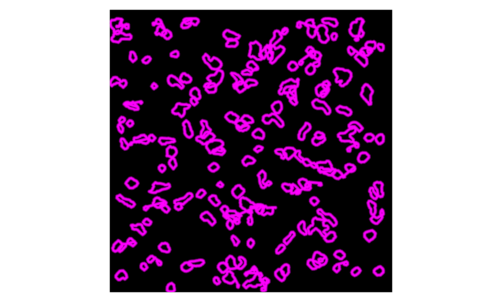

JupyterWgpuCanvas()

In [8]:
plot = Plot()
plot.add_graphic(background_graphic)
plot.add_graphic(contour_graphic)
plot.show()

In [9]:
def euclidean(source, target, event, new_data):
    """maps click events to contour"""
    # calculate coms of line collection
    indices = np.array(event.pick_info["index"])
    
    coms = list()

    for contour in target.graphics:
        coors = contour.data()[~np.isnan(contour.data()).any(axis=1)]
        com = coors.mean(axis=0)
        coms.append(com)

    # euclidean distance to find closest index of com 
    indices = np.append(indices, [0])
    
    ix = int(np.linalg.norm((coms - indices), axis=1).argsort()[0])
    
    target._set_feature(feature="colors", new_data=new_data, indices=ix)
    
    return None

In [10]:
background_graphic.link(
    "click",
    target=contour_graphic,
    feature="colors", 
    new_data="w", 
    callback=euclidean
)